In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import torchvision
from os.path import join
from PIL import Image
import numpy as np

In [2]:
import pickle

def get_input_labels(path):
    # Open the .pkl file for reading in binary mode
    with open(path, 'rb') as f:
        # Load the object from the file
        loaded_object = pickle.load(f)
#         list of dictionaries
        return loaded_object

In [3]:
def cal_rdm(embeddings):
    
    n = len(embeddings)
    # Convert embeddings to NumPy array
    embeddings_np = np.array([embedding.cpu().detach().numpy() for embedding in embeddings])
    # Reshape embeddings to 2D array (n x embedding_size)
    embeddings_flat = embeddings_np.reshape(n, -1)
    # Compute correlation coefficients for all pairs of embeddings
    rdm = 1 - np.corrcoef(embeddings_flat)

    return rdm


In [4]:
import numpy as np
from scipy.stats import spearmanr

# Function to perform RSA
def cal_rsa(rdm1, rdm2):
    # Flatten RDMs
    flat_rdm1 = rdm1.flatten()
    flat_rdm2 = rdm2.flatten()
    
    # Remove NaN values if present
    valid_indices = ~np.isnan(flat_rdm1) & ~np.isnan(flat_rdm2)
    flat_rdm1 = flat_rdm1[valid_indices]
    flat_rdm2 = flat_rdm2[valid_indices]
    
    # Calculate Spearman correlation coefficient
    rho, p_value = spearmanr(flat_rdm1, flat_rdm2)
    
    return rho



In [7]:
res_embeddings_path = '/kaggle/input/resnet-embeddings/embeddings_file(1).pkl'
res_embeddings_dict = get_input_labels(res_embeddings_path)

target_features = [ 'untrained', 'shape', 'color', 'texture']


In [8]:
layer_names = ['avgpool', 'fc']

In [10]:
rsa_bw_layers = {}

for feature in target_features:
#     for layer in layer_names:
    rdm1 = cal_rdm(res_embeddings_dict[feature]["avgpool"])
    rdm2 = cal_rdm(res_embeddings_dict[feature]["fc"])
    print("Calculating correlation coeff")
    corr = cal_rsa(rdm1, rdm2)
    rsa_bw_layers[feature] = corr
        

Calculating correlation coeff
Calculating correlation coeff
Calculating correlation coeff
Calculating correlation coeff


In [12]:
print(rsa_bw_layers)

{'untrained': 0.5992890891402778, 'shape': 0.981990103210654, 'color': 0.9010281902892493, 'texture': 0.748741538874468}


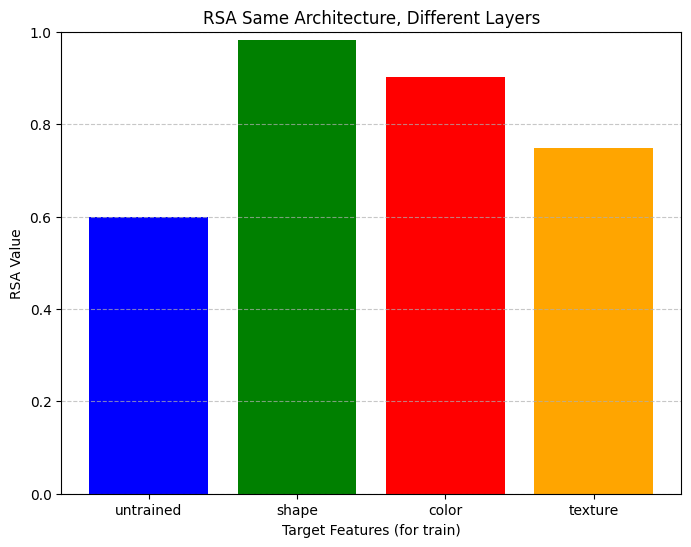

In [31]:
import matplotlib.pyplot as plt

values = list(rsa_bw_layers.values())
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(target_features, values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Target Features (for train)')
plt.ylabel('RSA Value')
plt.title('RSA Same Architecture, Different Layers')
plt.ylim(0, 1)  # Setting y-axis limits from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [16]:
rsa_diff_task = {}
n = len(target_features)

for layer in layer_names:
    rsa = [[0 for i in range(n)] for j in range(n)]
    for i in range(n):
        rdm1 = cal_rdm(res_embeddings_dict[target_features[i]][layer])
        for j in range(i, n):
            rdm2 = cal_rdm(res_embeddings_dict[target_features[j]][layer])
            corr = cal_rsa(rdm1, rdm2)
            rsa[i][j] = corr
            rsa[j][i] = corr
    rsa_diff_task[layer] = rsa

In [17]:
print(rsa_diff_task)

{'avgpool': [[1.0, 0.4287879836809958, 0.0031625132502890595, -0.0012988203778216607], [0.4287879836809958, 0.9999999999999999, -0.002346729590221179, -0.001429722030551725], [0.0031625132502890595, -0.002346729590221179, 1.0, 0.36487614335389634], [-0.0012988203778216607, -0.001429722030551725, 0.36487614335389634, 0.9999999999999999]], 'fc': [[0.9999999999999999, 0.31668505367798566, 0.005303949833475001, 0.003880825602958053], [0.31668505367798566, 0.9999999999999999, -0.002739209850761425, -0.0007644106704722901], [0.005303949833475001, -0.002739209850761425, 0.9999999999999999, 0.2262480666303383], [0.003880825602958053, -0.0007644106704722901, 0.2262480666303383, 1.0]]}


([<matplotlib.axis.YTick at 0x7e0ec8efcbe0>,
 [Text(0, 0, 'untrained'),
  Text(0, 1, 'shape'),
  Text(0, 2, 'color'),
  Text(0, 3, 'texture')])

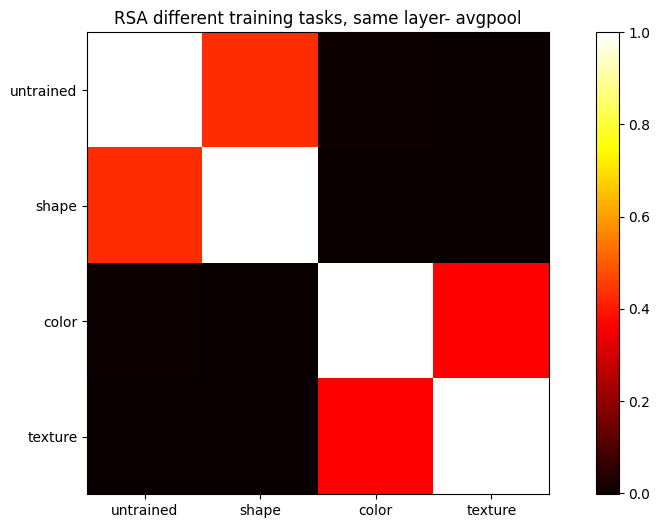

In [34]:
import matplotlib.pyplot as plt
import numpy as np

data = rsa_diff_task

# Extracting correlation values
avgpool_corr = np.array(data['avgpool'])
fc_corr = np.array(data['fc'])

# Plotting heatmap for avgpool
plt.figure(figsize=(12, 6))
plt.title('RSA different training tasks, same layer- avgpool')
plt.imshow(avgpool_corr, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(target_features)), labels=target_features)
plt.yticks(ticks=np.arange(len(target_features)), labels=target_features)


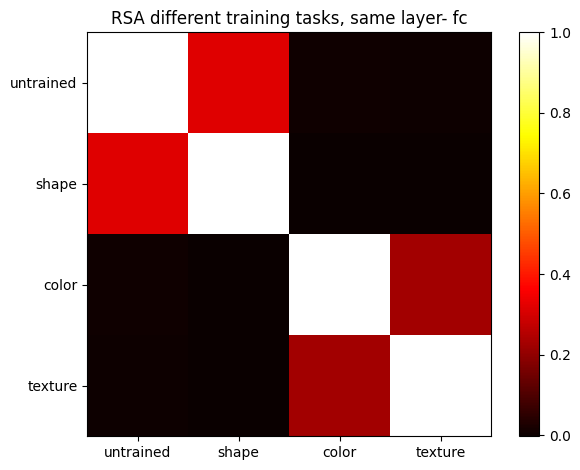

In [35]:
# Plotting heatmap for fc
plt.title('RSA different training tasks, same layer- fc')
plt.imshow(fc_corr, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=np.arange(len(target_features)), labels=target_features)
plt.yticks(ticks=np.arange(len(target_features)), labels=target_features)

plt.tight_layout()
plt.show()

In [19]:
eff_embeddings_path = '/kaggle/input/efficientnet-embeddings/embeddings_file(3).pkl'
eff_embeddings_dict = get_input_labels(eff_embeddings_path)


In [21]:
eff_layer_names = ['_avg_pooling', '_fc']

In [24]:
# diff arch, same features, same layer
rsa_diff_arch = {}

for i in range(2):
    rsa = {}
    for feature in target_features:
        rdm1 = cal_rdm(res_embeddings_dict[feature][layer_names[i]])
        rdm2 = cal_rdm(eff_embeddings_dict[feature][eff_layer_names[i]])
        print(rdm1.shape, rdm2.shape)
        corr = cal_rsa(rdm1, rdm2)
        rsa[feature] = corr
        
    rsa_diff_arch[layer_names[i]] = rsa

(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)


/opt/conda/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)
(3430, 3430) (3430, 3430)


In [25]:
print(rsa_diff_arch)

{'avgpool': {'untrained': 0.00016138760183248728, 'shape': -0.0018087528466023915, 'color': 0.004227714721926479, 'texture': 0.003922043760531379}, 'fc': {'untrained': nan, 'shape': -0.0018613749557936231, 'color': -0.0005776389661290766, 'texture': 0.0027500326746594853}}


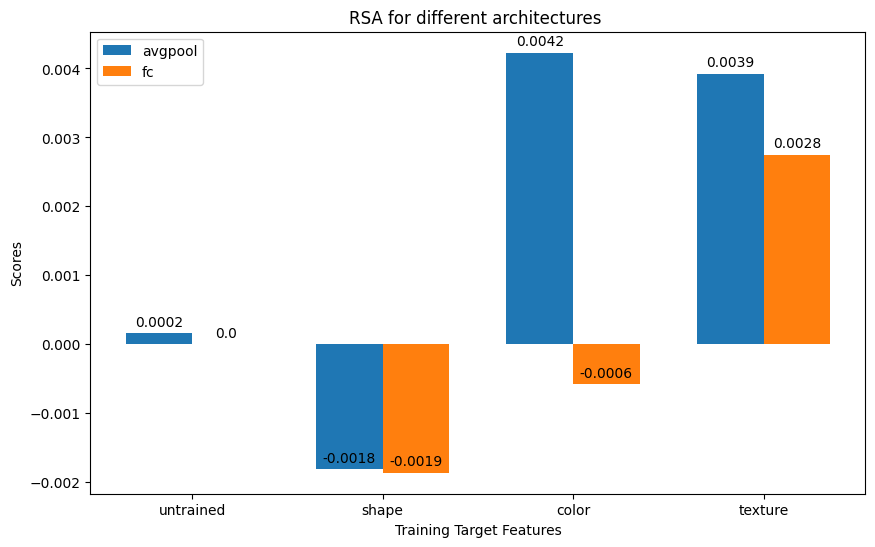

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data
rsa_diff_arch['fc']['untrained'] = 0
data = rsa_diff_arch
# Remove NaN values
# for key, value in data.items():
#     data[key] = {k: v for k, v in value.items() if not np.isnan(v)}

# Extracting labels and values
labels = list(data.keys())
values = [list(d.values()) for d in data.values()]
features = list(data['avgpool'].keys())

# Plotting
x = np.arange(len(features))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, values[0], width, label='avgpool')
rects2 = ax.bar(x + width/2, values[1], width, label='fc')

# Adding title and labels
ax.set_title('RSA for different architectures ')
ax.set_xlabel('Training Target Features')
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.legend()

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Displaying the plot
plt.show()
